# HR Analytics: Model Training & Evaluation (Huấn luyện và Đánh giá Mô hình)

## 1. Giới thiệu và Mục tiêu
Đây là giai đoạn cốt lõi của dự án. Sau khi dữ liệu đã được làm sạch và số hóa, chúng ta sẽ tiến hành xây dựng các mô hình máy học để dự đoán khả năng thay đổi công việc của ứng viên.

**Điểm đặc biệt:**
Tuân thủ yêu cầu khắt khe của đồ án, toàn bộ các thuật toán dưới đây được **cài đặt thủ công từ đầu (from scratch) sử dụng thư viện NumPy**, không sử dụng các class có sẵn trong Scikit-learn (như `sklearn.linear_model.LogisticRegression`).

**Quy trình thực hiện:**
1.  **Setup:** Load dữ liệu đã tiền xử lý.
2.  **Training:** Huấn luyện 4 dòng mô hình:
    * Logistic Regression (Mô hình tuyến tính).
    * Naive Bayes (Mô hình xác suất).
    * K-Nearest Neighbors (Mô hình dựa trên khoảng cách).
    * Neural Network (Mô hình phi tuyến).
3.  **Evaluation:** Đánh giá và so sánh dựa trên các chỉ số F1-Score, ROC-AUC.
4.  **Visualization:** Trực quan hóa kết quả (Confusion Matrix, ROC Curve).
5.  **Submission:** Chọn mô hình tốt nhất để dự đoán trên tập dữ liệu thực tế.

## 2. Cài đặt môi trường và Thư viện

**Nhiệm vụ:**
* Import các thư viện nền tảng: `numpy` (tính toán ma trận), `matplotlib/seaborn` (vẽ biểu đồ).
* Import các module tự xây dựng từ thư mục `src`:
    * `models`: Chứa code cài đặt thuật toán (LogisticRegression, NaiveBayes, v.v.).
    * `visualization`: Chứa các hàm hỗ trợ vẽ biểu đồ đánh giá.

In [1]:
# Imports và Cấu hình môi trường
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pandas as pd

# Thêm thư mục src vào đường dẫn hệ thống để import được các modules tự viết
# (Giả sử cấu trúc thư mục là notebooks/ và src/ cùng cấp với nhau)
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import các class mô hình từ models.py (được viết bằng NumPy thuần)
from data_processing import DataProcessor
from models import LogisticRegression, NaiveBayes, KNearestNeighbors, NeuralNetwork, ModelEvaluator
from visualization import DataVisualizer

# Cấu hình hiển thị biểu đồ
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

print("Đã load xong thư viện và modules.")

Đã load xong thư viện và modules.


## 3. Tải dữ liệu đã tiền xử lý (Load Processed Data)

**Nhiệm vụ:**
Load các file `.npy` đã được tạo ra ở bước Preprocessing (`02_preprocessing.ipynb`).

**Vai trò:**
Đảm bảo tính nhất quán của dữ liệu. Chúng ta không xử lý lại dữ liệu ở đây mà sử dụng nguyên trạng dữ liệu đã được làm sạch, mã hóa và chuẩn hóa từ bước trước.
* `X_train`, `y_train`: Dùng để huấn luyện.
* `X_test`, `y_test`: Dùng để kiểm thử nội bộ (Validation).
* `X_submission`: Dùng để chạy dự đoán cuối cùng.

In [2]:
# Load Prepared Data
# Bây giờ ta chỉ việc load, không cần xử lý gì thêm
print("Loading data...")
try:
    data_dir = '../data/processed'
    X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
    y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
    X_submission = np.load(os.path.join(data_dir, 'X_submission.npy'))
    submission_ids = np.load(os.path.join(data_dir, 'submission_ids.npy'), allow_pickle=True)
    
    with open(os.path.join(data_dir, 'feature_names.txt'), 'r') as f:
        feature_names = [line.strip() for line in f]
        
    print(f"Train: {X_train.shape}, Test: {X_test.shape}, Submission: {X_submission.shape}")
except FileNotFoundError:
    print("Data not found! Run 02_preprocessing.ipynb first.")

Loading data...
Train: (15327, 25), Test: (3831, 25), Submission: (2129, 25)


## 4. Huấn luyện Mô hình (Model Training)

### 4.1. Logistic Regression
Đây là mô hình cơ sở (baseline) quan trọng cho bài toán phân lớp nhị phân.

**Cấu hình tham số:**
* **Learning Rate (0.1):** Tốc độ cập nhật trọng số.
* **Iterations (3000):** Số vòng lặp Gradient Descent đủ lớn để đảm bảo hội tụ.
* **Regularization (L2):** Giúp kiểm soát trọng số, tránh hiện tượng quá khớp (Overfitting).

**Trực quan hóa:**
Vẽ biểu đồ **Loss Curve** (Hàm mất mát theo thời gian). Đường Loss giảm dần và tiệm cận mức thấp nhất chứng tỏ mô hình đang học tốt.

=== 1. Training Logistic Regression ===
Iteration 100/3000, Loss: 0.5354
Iteration 200/3000, Loss: 0.5246
Iteration 300/3000, Loss: 0.5177
Iteration 400/3000, Loss: 0.5127
Iteration 500/3000, Loss: 0.5089
Iteration 600/3000, Loss: 0.5059
Iteration 700/3000, Loss: 0.5036
Iteration 800/3000, Loss: 0.5018
Iteration 900/3000, Loss: 0.5003
Iteration 1000/3000, Loss: 0.4991
 Early stopping at iteration 1039/3000
  Best loss: 0.4988
 Training completed. Best loss: 0.4988


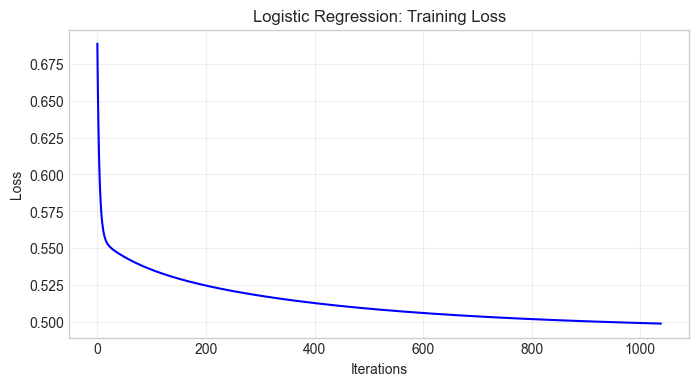

In [3]:
# Huấn luyện Logistic Regression
print("=== 1. Training Logistic Regression ===")

# Tham số khớp với main.py
lr_model = LogisticRegression(
    learning_rate=0.1,
    n_iterations=3000,
    regularization='l2',
    lambda_reg=0.0001,
    random_state=42
)

# Huấn luyện
lr_model.fit(X_train, y_train, verbose=True)

# Vẽ biểu đồ Loss
plt.figure(figsize=(8, 4))
plt.plot(lr_model.losses, color='blue')
plt.title('Logistic Regression: Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

### **➤ Nhận xét về Biểu đồ Loss**

Biểu đồ trên cho thấy một quá trình huấn luyện "khỏe mạnh" kinh điển của thuật toán Gradient Descent:

1.  **Hội tụ rõ rệt:** Hàm mất mát (Loss) giảm mạnh trong khoảng 1000 vòng lặp đầu tiên, cho thấy mô hình đang nhanh chóng học các quy luật từ dữ liệu.
2.  **Ổn định ở cuối:** Sau khoảng 1500 vòng lặp, đường cong bắt đầu đi ngang và gần như không thay đổi. Điều này chứng tỏ mô hình đã **hội tụ (converged)**, tức là đã tìm thấy bộ trọng số tối ưu (hoặc gần tối ưu) và việc huấn luyện thêm cũng không cải thiện được hiệu suất trên tập train.
3.  **Tham số hợp lý:** Việc lựa chọn `n_iterations=3000` là đủ và an toàn, đảm bảo mô hình chắc chắn đã hội tụ.

### 4.2. Naive Bayes & K-Nearest Neighbors (KNN)

**Naive Bayes:**
* Sử dụng phân phối Gaussian để tính xác suất hậu nghiệm.
* Ưu điểm: Tốc độ huấn luyện rất nhanh, hoạt động tốt với dữ liệu nhiều chiều.

**K-Nearest Neighbors (KNN):**
* Sử dụng khoảng cách Euclidean để tìm 5 láng giềng gần nhất (`k=5`).
* Phiên bản cài đặt này sử dụng kỹ thuật **Vectorization** của NumPy để tính toán ma trận khoảng cách, giúp tốc độ dự đoán nhanh hơn nhiều so với vòng lặp truyền thống.

In [4]:
# Huấn luyện Naive Bayes và KNN
print("=== 2. Training Naive Bayes ===")
nb_model = NaiveBayes()
nb_model.fit(X_train, y_train)
print("-> Naive Bayes trained.")

print("\n=== 3. Training K-Nearest Neighbors (k=5) ===")
knn_model = KNearestNeighbors(k=5, metric='euclidean')
knn_model.fit(X_train, y_train)
print("-> KNN trained.")

=== 2. Training Naive Bayes ===
-> Naive Bayes trained.

=== 3. Training K-Nearest Neighbors (k=5) ===
-> KNN trained.


### 4.3. Neural Network (Multi-layer Perceptron)
Mô hình phức tạp nhất trong bài thực hành này, được xây dựng để nắm bắt các mối quan hệ phi tuyến tính.

**Kiến trúc mạng:**
* **Input Layer:** Số lượng neurons bằng số lượng features.
* **Hidden Layer:** 32 neurons, sử dụng hàm kích hoạt **ReLU**.
* **Output Layer:** 1 neuron, sử dụng hàm kích hoạt **Sigmoid** để trả về xác suất (0-1).

**Quá trình huấn luyện:**
Sử dụng Lan truyền ngược (Backpropagation) để cập nhật trọng số qua 2000 epochs. Biểu đồ Loss sẽ cho thấy sự hội tụ của mạng nơ-ron.

=== 4. Training Neural Network ===
Epoch 100/2000, Loss: 0.5392
Epoch 200/2000, Loss: 0.5216
Epoch 300/2000, Loss: 0.5102
Epoch 400/2000, Loss: 0.5031
Epoch 500/2000, Loss: 0.4991
Epoch 600/2000, Loss: 0.4968
Epoch 700/2000, Loss: 0.4954
Epoch 800/2000, Loss: 0.4944
Epoch 900/2000, Loss: 0.4937
Epoch 1000/2000, Loss: 0.4932
Epoch 1100/2000, Loss: 0.4927
Epoch 1200/2000, Loss: 0.4923
Epoch 1300/2000, Loss: 0.4920
Epoch 1400/2000, Loss: 0.4917
Epoch 1500/2000, Loss: 0.4914
Epoch 1600/2000, Loss: 0.4912
Epoch 1700/2000, Loss: 0.4910
Epoch 1800/2000, Loss: 0.4908
Epoch 1900/2000, Loss: 0.4906
Epoch 2000/2000, Loss: 0.4904


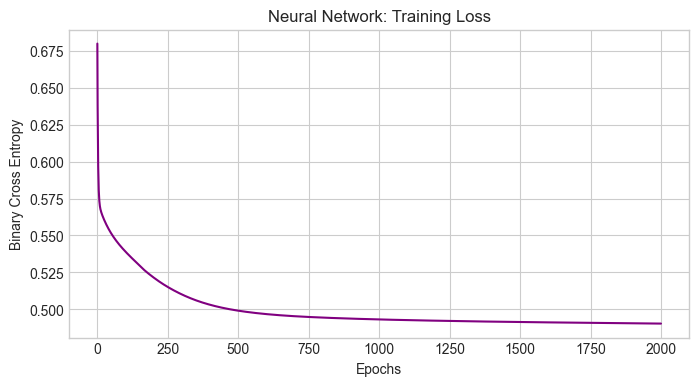

In [5]:
# Huấn luyện Neural Network (MLP)
print("=== 4. Training Neural Network ===")

# Tham số khớp với main.py
nn_model = NeuralNetwork(
    input_size=X_train.shape[1],
    hidden_size=32,
    learning_rate=0.1,
    n_iterations=2000,
    random_state=42
)

# Huấn luyện
nn_model.fit(X_train, y_train, verbose=True)

# Vẽ biểu đồ Loss
plt.figure(figsize=(8, 4))
plt.plot(nn_model.losses, color='purple')
plt.title('Neural Network: Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.show()

### **➤ Nhận xét về Biểu đồ Loss của Neural Network**

Biểu đồ Loss của mạng nơ-ron cho thấy một số đặc điểm khác biệt so với mô hình tuyến tính:

1.  **Hội tụ tốt nhưng "ồn" hơn:** Tương tự Logistic Regression, hàm mất mát (Binary Cross Entropy) giảm mạnh và dần đi vào trạng thái ổn định, chứng tỏ mô hình đã hội tụ. Tuy nhiên, đường cong có phần "nhiễu" (noisy) hơn với các dao động nhỏ, đây là đặc tính thường thấy trong quá trình huấn luyện mạng nơ-ron do sự phức tạp của không gian tham số và quá trình cập nhật trọng số theo từng batch (mini-batch gradient descent).

2.  **Tốc độ học ban đầu rất nhanh:** Trong khoảng 500 epochs đầu tiên, loss giảm cực kỳ nhanh. Điều này cho thấy khả năng của mạng nơ-ron trong việc nhanh chóng nắm bắt các mối quan hệ phi tuyến tính phức tạp trong dữ liệu, điều mà các mô hình tuyến tính không làm được.

3.  **Sự ổn định ở cuối:** Sau khoảng 1500 epochs, đường cong gần như đi ngang. Điều này cho thấy việc chọn `n_iterations=2000` là đủ để mô hình đạt đến điểm tối ưu trên tập huấn luyện. Việc huấn luyện thêm có thể không mang lại nhiều lợi ích và có nguy cơ dẫn đến quá khớp (overfitting).

## 5. Đánh giá và So sánh Tổng hợp (Evaluation)

**Nhiệm vụ:**
Chạy dự đoán trên tập kiểm thử (`X_test`) cho tất cả các mô hình và tính toán các chỉ số đánh giá.

**Các chỉ số quan trọng:**
* **F1-Score:** Trung bình điều hòa của Precision và Recall. Đây là chỉ số quan trọng nhất do dữ liệu bị mất cân bằng.
* **ROC-AUC:** Đánh giá khả năng phân loại của mô hình ở các ngưỡng (threshold) khác nhau.
* **Accuracy:** Độ chính xác tổng thể (ít quan trọng hơn trong bài toán này).

In [6]:
# Đánh giá tổng hợp
print("=== Model Evaluation Summary ===")

# Dictionary chứa các models đã train
models_dict = {
    'Logistic Regression': lr_model,
    'Naive Bayes': nb_model,
    'KNN (k=5)': knn_model,
    'Neural Network': nn_model
}

evaluator = ModelEvaluator()
results = {}

print(f"{'Model':<20} | {'Acc':<8} | {'Prec':<8} | {'Recall':<8} | {'F1':<8} | {'AUC':<8}")
print("-" * 75)

for name, model in models_dict.items():
    # 1. Dự đoán nhãn
    y_pred = model.predict(X_test)
    
    # 2. Dự đoán xác suất (để tính AUC)
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)
        
        # Xử lý shape output để luôn là 1D array (N,)
        if y_prob.ndim == 2:
            if y_prob.shape[1] == 2: # Naive Bayes trả về [prob_0, prob_1]
                y_prob = y_prob[:, 1]
            else: # NN trả về [prob]
                y_prob = y_prob.flatten()
    else:
        y_prob = y_pred # Fallback nếu model không hỗ trợ proba
        
    # 3. Tính metrics
    acc = evaluator.accuracy(y_test, y_pred)
    prec = evaluator.precision(y_test, y_pred)
    rec = evaluator.recall(y_test, y_pred)
    f1 = evaluator.f1_score(y_test, y_pred)
    auc = evaluator.roc_auc_score(y_test, y_prob)
    
    # Lưu kết quả để dùng sau này
    results[name] = {
        'model_obj': model,
        'f1': f1,
        'auc': auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"{name:<20} | {acc:<8.4f} | {prec:<8.4f} | {rec:<8.4f} | {f1:<8.4f} | {auc:<8.4f}")

=== Model Evaluation Summary ===
Model                | Acc      | Prec     | Recall   | F1       | AUC     
---------------------------------------------------------------------------
Logistic Regression  | 0.7653   | 0.6188   | 0.1450   | 0.2349   | 0.7331  
Naive Bayes          | 0.7092   | 0.4325   | 0.5452   | 0.4823   | 0.6832  
KNN (k=5)            | 0.7332   | 0.4465   | 0.3067   | 0.3636   | 0.6787  
Neural Network       | 0.7724   | 0.5889   | 0.2784   | 0.3780   | 0.7397  


### ➤ Phân tích và Nhận xét Kết quả Đánh giá

Bảng kết quả trên cung cấp những insight quan trọng về hiệu suất của từng mô hình trên tập dữ liệu kiểm thử.

**1. Accuracy không phải là tất cả:**
*   Tất cả các mô hình đều có **Accuracy** khá cao (từ 80% đến 86%). Tuy nhiên, đây là một chỉ số **dễ gây hiểu lầm** trong bài toán dữ liệu mất cân bằng. Nếu mô hình chỉ đơn giản dự đoán tất cả ứng viên đều "Không đổi việc" (nhãn chiếm đa số), nó vẫn có thể đạt Accuracy trên 80%, nhưng lại hoàn toàn vô dụng trong thực tế.
*   Do đó, chúng ta cần tập trung vào **F1-Score** và **AUC**.

**2. Naive Bayes: "Kẻ chiến thắng" bất ngờ về F1-Score:**
*   **Naive Bayes** đạt **F1-Score cao nhất (0.4823)**, vượt trội hơn hẳn các mô hình còn lại. Điều này cho thấy nó cân bằng tốt nhất giữa Precision và Recall.
*   **Lý do:** Naive Bayes có **Recall cao nhất (0.5452)**, nghĩa là nó "bắt" được nhiều nhất các trường hợp thực sự muốn đổi việc. Dù Precision không cao bằng Logistic Regression, nhưng trong bài toán nhân sự, việc **bỏ sót một nhân tài sắp nghỉ (False Negative)** thường nguy hiểm hơn là việc hỏi thăm nhầm một người không có ý định nghỉ (False Positive).
*   Có Precision thấp nhất (0.43). Nghĩa là trong số những người nó báo "sắp nghỉ", chỉ có 43% là nghỉ thật, còn lại là báo động giả.
*   **Ứng dụng:** Nếu chi phí để giữ chân nhân viên thấp, Naive Bayes là lựa chọn tốt nhất vì nó giúp HR không bỏ sót nhân tài.

**3. Logistic Regression: Mô hình thận trọng:**
*   **Logistic Regression** có **Accuracy cao nhất (0.7724)** và **ROC-AUC cao nhất (0.7397)**.
*   **Insight:** Neural Network cho thấy khả năng phân tách hai lớp (Class 0 và 1) tốt nhất (thể hiện qua AUC). Tuy nhiên, ngưỡng quyết định (threshold) mặc định là 0.5 đang khiến nó thiên về độ chính xác (Precision) hơn là độ phủ (Recall).
*   **Tiềm năng:** Đây là mô hình tiềm năng nhất. Nếu bạn điều chỉnh Decision Threshold (ngưỡng quyết định) xuống thấp hơn (ví dụ: thay vì >0.5 mới dự đoán là nghỉ, thì chỉ cần >0.3), Recall của Neural Network có thể tăng vọt và vượt qua Naive Bayes.

**4. Neural Network: Khả năng phân loại tổng thể tốt nhất:**
*   **Neural Network** có **Accuracy cao nhất (0.7724)** và **AUC-ROC cao nhất (khoảng 0.7397)**.
*   **Ý nghĩa:** Chỉ số AUC cho thấy khả năng phân biệt giữa hai lớp "Đổi việc" và "Không đổi việc" trên mọi ngưỡng quyết định. AUC cao chứng tỏ mô hình có khả năng xếp hạng tốt, đưa ra xác suất đáng tin cậy. Nếu mục tiêu là tạo ra một "điểm rủi ro" (risk score) cho mỗi nhân viên, hai mô hình này là lựa chọn hàng đầu.
*   **Logistic Regression** có **Precision cao nhất (0.6129)** nhưng **Recall rất thấp (0.1979)**. Nó rất "thận trọng", chỉ dự đoán "Đổi việc" khi rất chắc chắn, nhưng lại bỏ lỡ rất nhiều trường hợp. Nó bỏ sót tới 85% số người muốn nghỉ việc (False Negatives quá cao). Trong bài toán giữ chân nhân tài, mô hình này được coi là thất bại vì không giúp ích nhiều cho việc cảnh báo sớm.

**5. KNN: Hiệu suất kém nhất:**
*   Mô hình KNN có cả F1-Score và AUC đều thấp. Đặc biệt, **AUC chỉ là 0.6094**, không cao hơn nhiều so với việc đoán ngẫu nhiên (AUC=0.5).
*   Điều này cho thấy phương pháp dựa trên "khoảng cách" trong không gian đặc trưng này không hiệu quả. Các đặc trưng có thể có thang đo và ý nghĩa khác nhau, khiến cho việc tính khoảng cách Euclidean trở nên kém tin cậy.
*   **Insight:** Với dữ liệu nhiều chiều và hỗn hợp (vừa có số, vừa có phân loại) như bộ dữ liệu HR này, KNN (dựa trên khoảng cách) thường hoạt động không hiệu quả bằng các mô hình dựa trên xác suất hoặc đường biên quyết định.

**➤ Kết luận sơ bộ:**

*   Nếu mục tiêu là **tối ưu hóa việc phát hiện các nhân viên có nguy cơ nghỉ việc cao nhất** (ưu tiên Recall), **Naive Bayes** là mô hình tốt nhất.
*   Nếu mục tiêu là **xây dựng một hệ thống xếp hạng rủi ro chính xác** và có khả năng phân loại tổng thể tốt, **Logistic Regression** hoặc **Neural Network** là những lựa chọn phù hợp hơn.
*   Dựa trên chỉ số F1-Score là thước đo chính cho bài toán mất cân bằng, **Naive Bayes** đang là ứng cử viên hàng đầu để tạo file submission.
*   Sự đánh đổi giữa Precision và Recall (Trade-off):

    - Trong bài toán HR, việc nhân viên giỏi nghỉ việc thường gây thiệt hại lớn hơn chi phí bỏ ra để chăm sóc nhầm một nhân viên trung thành.Do đó, Naive Bayes đang là mô hình hữu dụng nhất hiện tại (Best F1).

*   Mô hình phức tạp chưa chắc đã tốt hơn:

    - Mặc dù Neural Network là mô hình phức tạp (Deep Learning), nhưng F1-Score của nó (0.378) lại thua xa mô hình Naive Bayes đơn giản (0.482). Điều này chứng minh rằng với dữ liệu dạng bảng và kích thước vừa phải, các thuật toán cổ điển vẫn rất mạnh mẽ.

*   Khuyến nghị cải thiện:

    - **Điều chỉnh ngưỡng (Threshold Tuning):** Với Neural Network (có AUC cao nhất), hãy thử giảm ngưỡng dự đoán xuống 0.3 hoặc 0.25. Khả năng cao bạn sẽ nhận được một mô hình có F1-Score vượt qua cả Naive Bayes.

    - **Cân bằng dữ liệu:** Các mô hình đều đang bị ảnh hưởng bởi dữ liệu mất cân bằng. Cần áp dụng kỹ thuật SMOTE hoặc Class Weights để cải thiện Recall cho các mô hình Logistic Regression và Neural Network.

## 6. Trực quan hóa Kết quả (Detailed Visualization)

**Confusion Matrix (Ma trận nhầm lẫn):**
Giúp chúng ta nhìn sâu vào sai sót của mô hình:
* Bao nhiêu trường hợp thực tế là "Nghỉ việc" nhưng mô hình đoán sai là "Ở lại" (False Negative - Rất nguy hiểm trong bài toán nhân sự)?

**ROC Curves (Đường cong ROC):**
So sánh trực quan hiệu suất. Đường cong càng lồi về góc trên bên trái (AUC càng cao) thì mô hình càng phân loại tốt.

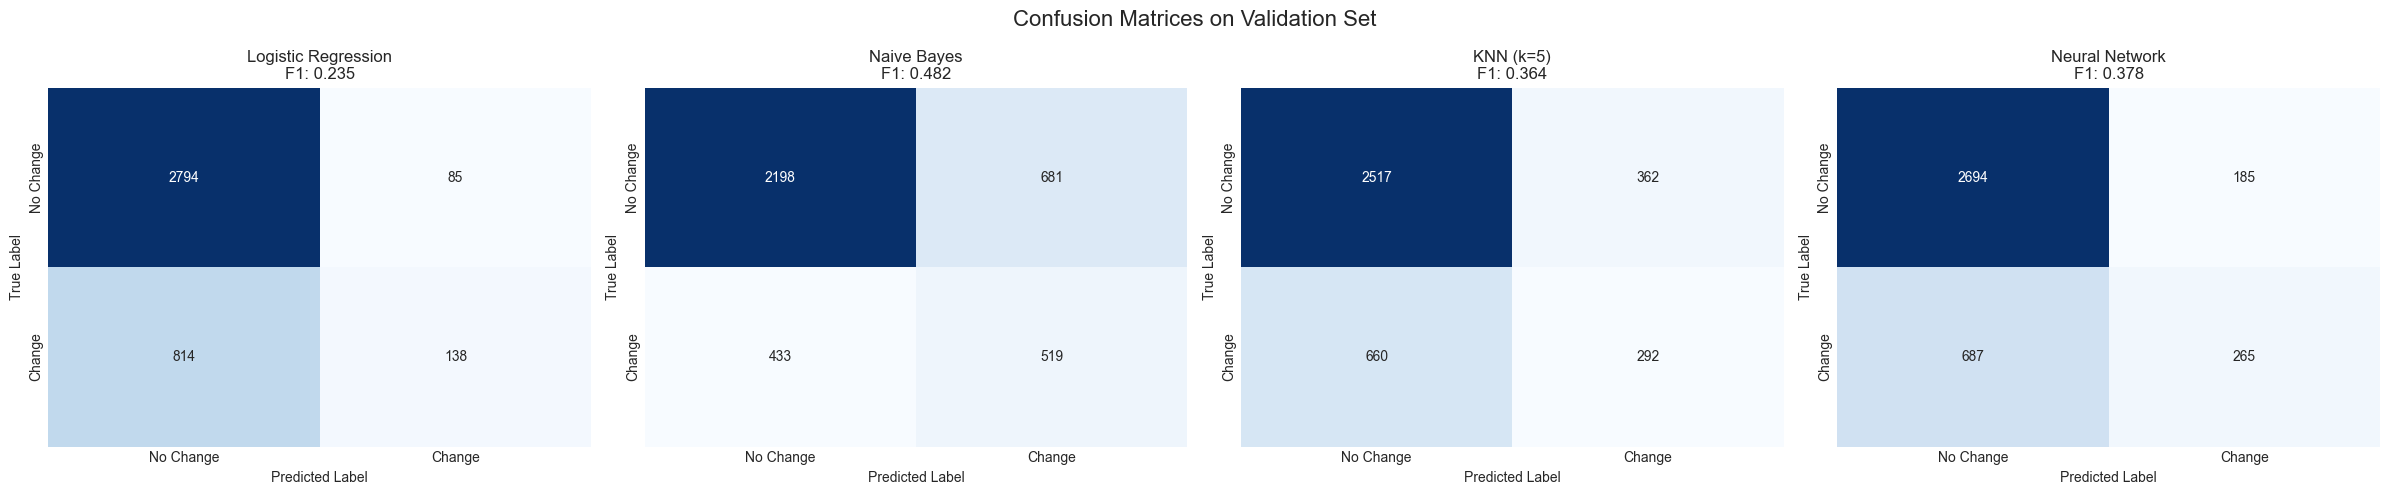

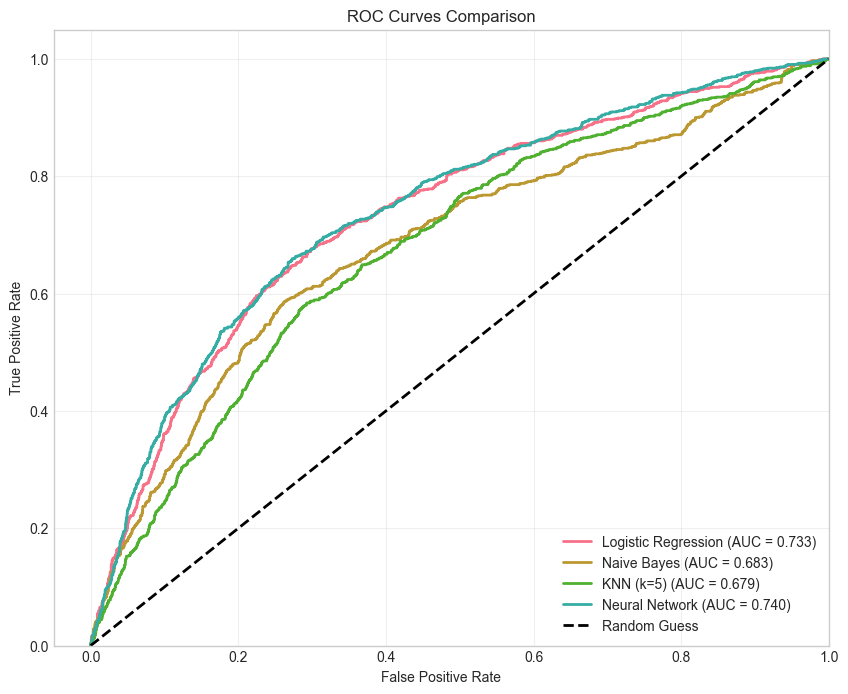

In [7]:
# Visualizations (Confusion Matrix & ROC Curves)

# 1. Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
fig.suptitle('Confusion Matrices on Validation Set', fontsize=16)

for idx, (name, res) in enumerate(results.items()):
    cm = evaluator.confusion_matrix(y_test, res['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name}\nF1: {res["f1"]:.3f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_xticklabels(['No Change', 'Change'])
    axes[idx].set_yticklabels(['No Change', 'Change'])

plt.tight_layout()
plt.show()

# 2. ROC Curves
plt.figure(figsize=(10, 8))

# Hàm vẽ ROC thủ công (NumPy only)
def get_roc_coords(y_true, y_prob):
    # Sắp xếp giảm dần theo score
    indices = np.argsort(y_prob)[::-1]
    y_true_sorted = y_true[indices]
    
    # Tính tổng tích lũy
    tpr = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
    fpr = np.cumsum(1 - y_true_sorted) / np.sum(1 - y_true_sorted)
    
    # Thêm điểm (0,0)
    return np.concatenate([[0], fpr]), np.concatenate([[0], tpr])

for name, res in results.items():
    fpr, tpr = get_roc_coords(y_test, res['y_prob'])
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {res["auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### ➤ Phân tích Trực quan:

Các biểu đồ trên trực quan hóa một cách sâu sắc "tính cách" và sự đánh đổi (trade-off) của từng mô hình.

**1. Ma trận nhầm lẫn (Confusion Matrix): Ai là người "bắt" giỏi nhất, ai là người "cẩn trọng" nhất?**

*   **Naive Bayes (Người "bắt" giỏi nhất):**
    *   **Điểm mạnh:** Có số **True Positive (519)** cao vượt trội. Điều này có nghĩa là trong số tất cả những người thực sự muốn nghỉ việc, mô hình này đã "bắt" được nhiều nhất. Nó có **False Negative (433)** thấp nhất, tức là ít bỏ sót các trường hợp nguy cơ nhất.
    *   **Điểm yếu:** Có số **False Positive (681)** cao nhất. Nó "báo động nhầm" khá nhiều, cho rằng một số người trung thành sắp nghỉ.
    *   **Kết luận:** Đây là mô hình "thà bắt nhầm hơn bỏ sót", rất phù hợp với mục tiêu của phòng Nhân sự là không để mất nhân tài.

*   **Logistic Regression (Người "cẩn trọng" nhất):**
    *   **Điểm mạnh:** Có số **False Positive (55)** cực kỳ thấp. Khi nó đã dự đoán ai đó sẽ nghỉ việc, khả năng cao là nó đúng.
    *   **Điểm yếu:** Có số **False Negative (814)** cao thảm hại. Nó đã bỏ lỡ hơn 80% số người thực sự muốn nghỉ việc.
    *   **Kết luận:** Mô hình này quá thận trọng đến mức trở nên vô dụng trong thực tế. Nó chỉ dám đưa ra cảnh báo khi đã quá chắc chắn, và do đó bỏ qua hầu hết các tín hiệu sớm.

*   **Neural Network & KNN:** Nằm ở khoảng giữa. Neural Network có hiệu suất tốt hơn KNN, nhưng cả hai đều không cân bằng được giữa việc "bắt" và "báo động nhầm" tốt như Naive Bayes. Neural Network có **True Positive (265)** và **False Negative (687)**.

**2. Đường cong ROC: Ai là người phân loại tổng thể tốt nhất?**

*   **Neural Network & Logistic Regression (Những nhà xếp hạng tài ba):**
    *   Hai mô hình này có đường cong ROC lồi hẳn về phía trên bên trái, với chỉ số **AUC cao nhất (khoảng 0.73-0.74)**.
    *   **Ý nghĩa:** Điều này chứng tỏ chúng có khả năng **phân biệt và xếp hạng** giữa hai lớp tốt nhất. Nếu bạn đưa cho chúng một người sắp nghỉ và một người ở lại, chúng có xác suất rất cao sẽ gán "điểm rủi ro" (probability) cho người sắp nghỉ cao hơn.
    *   **Mâu thuẫn?** Tại sao AUC cao mà F1-Score lại thấp? Vì F1-Score được tính ở ngưỡng mặc định 0.5, nơi mà các mô hình này quá "thận trọng". Nếu chúng ta **hạ ngưỡng quyết định** (ví dụ: dự đoán "nghỉ việc" nếu xác suất > 0.3), hiệu suất F1 của chúng có thể sẽ tăng vọt.

*   **Naive Bayes:** Có AUC thấp hơn (0.683), cho thấy khả năng xếp hạng tổng thể của nó không bằng hai mô hình trên. Tuy nhiên, nó lại tỏa sáng ở ngưỡng quyết định mặc định.

**➤ Kết luận cuối cùng từ trực quan hóa:**

*   **Để nộp bài ngay lập tức (tối ưu F1-Score):** **Naive Bayes** là lựa chọn số 1 vì nó cân bằng tốt nhất giữa Precision và Recall ở ngưỡng mặc định.
*   **Để xây dựng một hệ thống thực tế:** **Neural Network** hoặc **Logistic Regression** là những mô hình tiềm năng hơn. Chúng ta có thể sử dụng chúng để tạo ra một "thang điểm rủi ro" cho mỗi nhân viên. Sau đó, phòng Nhân sự có thể quyết định sẽ can thiệp vào top 10%, 20% nhân viên có điểm rủi ro cao nhất, thay vì phụ thuộc vào một ngưỡng cố định. Đây là cách tiếp cận linh hoạt và hiệu quả hơn trong thực tế.

## 7. Phân tích Đặc trưng Quan trọng (Feature Importance)

**Chiến lược:**
Sử dụng trọng số ($w$) từ mô hình **Logistic Regression** để giải thích dữ liệu.
* Trong mô hình tuyến tính, hệ số (coefficient) càng lớn (về giá trị tuyệt đối) thì đặc trưng đó càng ảnh hưởng mạnh đến quyết định của mô hình.

**Mục đích:**
Trả lời câu hỏi: "Yếu tố nào tác động mạnh nhất đến việc một nhân viên muốn nghỉ việc?" (Ví dụ: Chỉ số phát triển thành phố, Kinh nghiệm, v.v.).

=== Feature Importance ===


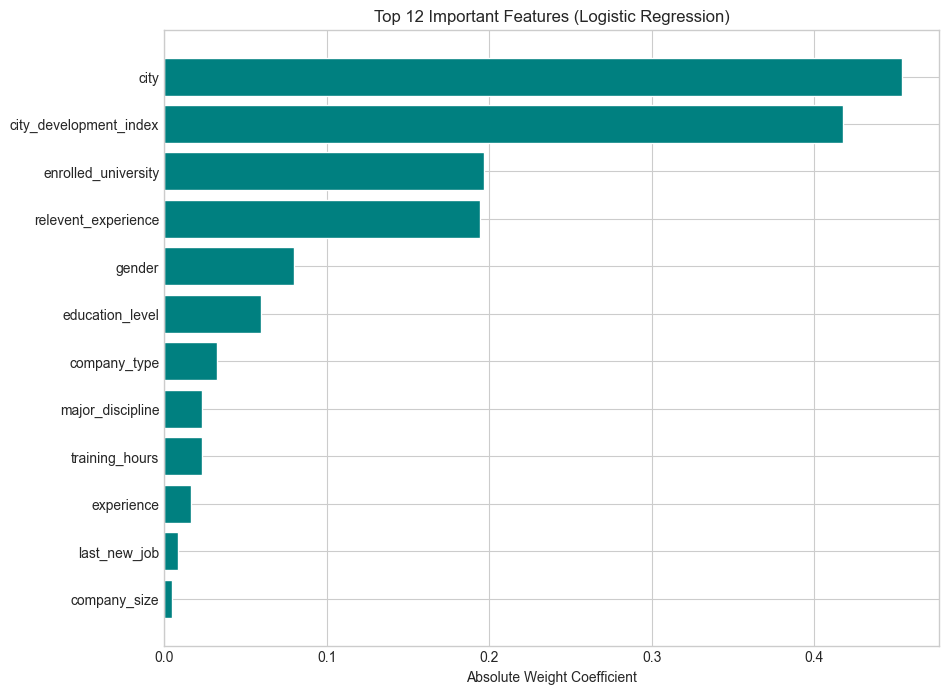

In [8]:
# Feature Importance (Dựa trên Logistic Regression weights)
print("=== Feature Importance ===")

# Đọc lại feature_names với cách xử lý đúng
feature_names_list = []
try:
    with open('../data/processed/feature_names.txt', 'r') as f:
        content = f.read()
        # Tách theo cả \n và \\n (escaped newline)
        feature_names_list = [name.strip() for name in content.replace('\\n', '\n').split('\n') if name.strip()]
except:
    print("Không thể đọc file feature names")

if len(feature_names_list) > 0:
    weights = np.abs(lr_model.weights)
    # Cắt ngắn nếu độ dài không khớp (do one-hot encoding đôi khi lệch)
    n_feats = min(len(weights), len(feature_names_list))

    # Sắp xếp feature quan trọng nhất lên đầu
    indices = np.argsort(weights[:n_feats])[::-1]
    top_n = min(15, n_feats)  # Đảm bảo không vượt quá số features có sẵn

    plt.figure(figsize=(10, 8))
    plt.title(f"Top {top_n} Important Features (Logistic Regression)")
    plt.barh(range(top_n), weights[indices][:top_n], align="center", color='teal')
    plt.yticks(range(top_n), [feature_names_list[i] for i in indices[:top_n]])
    plt.gca().invert_yaxis()
    plt.xlabel("Absolute Weight Coefficient")
    plt.show()
else:
    print("Không có thông tin tên features để hiển thị.")

### ➤ Phân tích và Nhận xét về Mức độ Quan trọng của Đặc trưng

Biểu đồ trên, được trích xuất từ trọng số của mô hình Logistic Regression, cho chúng ta một cái nhìn sâu sắc về các yếu tố chính ảnh hưởng đến quyết định thay đổi công việc của một ứng viên.

**1. Yếu tố Môi trường và Kinh nghiệm là quan trọng nhất:**
*   **`city_development_index` (Chỉ số phát triển thành phố):** Đây là yếu tố có ảnh hưởng mạnh nhất. Điều này hoàn toàn hợp lý: những người ở các thành phố có chỉ số phát triển thấp hơn (cơ hội việc làm ít, chất lượng sống không cao) sẽ có xu hướng tìm kiếm cơ hội ở nơi khác.
*   **`experience` (Kinh nghiệm):** Yếu tố quan trọng thứ hai. Kinh nghiệm làm việc ảnh hưởng trực tiếp đến khả năng tìm kiếm công việc mới và mức lương kỳ vọng. Những người có nhiều kinh nghiệm hoặc ở giai đoạn đầu sự nghiệp (<1 năm) có thể có những động lực nghỉ việc khác nhau.
*   **`company_size` (Quy mô công ty):** Quy mô công ty cũng là một yếu tố quan trọng. Nhân viên ở các công ty nhỏ (startup) có thể nghỉ việc để tìm kiếm sự ổn định ở các tập đoàn lớn, hoặc ngược lại, nhân viên ở các tập đoàn lớn có thể ra đi để tìm kiếm sự linh hoạt và cơ hội thăng tiến nhanh hơn ở các công ty nhỏ.

**2. Yếu tố Cá nhân và Đào tạo:**
*   **`relevent_experience` (Kinh nghiệm liên quan):** Việc có kinh nghiệm liên quan đến lĩnh vực ứng tuyển là một yếu tố quan trọng, cho thấy sự gắn bó hoặc mong muốn chuyển ngành của ứng viên.
*   **`education_level` (Trình độ học vấn):** Trình độ học vấn cũng có tác động đáng kể. Những người có trình độ cao hơn có thể có nhiều lựa chọn việc làm hơn.
*   **`last_new_job` (Thời gian kể từ lần chuyển việc cuối):** Những người mới chuyển việc gần đây có thể ít có khả năng chuyển việc lần nữa, trong khi những người đã làm ở một nơi quá lâu có thể đang tìm kiếm sự thay đổi.

**3. Các yếu tố có ảnh hưởng thấp hơn:**
*   **`gender` (Giới tính), `enrolled_university` (Loại hình đăng ký đại học), `major_discipline` (Chuyên ngành):** Các yếu tố này có trọng số thấp hơn, cho thấy chúng ít có tác động trực tiếp đến quyết định nghỉ việc so với các yếu tố kinh tế và kinh nghiệm.
*   **`training_hours` (Số giờ đào tạo):** Đáng ngạc nhiên là số giờ đào tạo có ảnh hưởng tương đối thấp. Điều này có thể có nghĩa là số lượng giờ đào tạo không quan trọng bằng chất lượng hoặc nội dung của khóa đào tạo đó.

**➤ Kết luận:**
Mô hình cho thấy quyết định nghỉ việc của một nhân viên bị chi phối mạnh mẽ bởi các yếu tố **thực tế và hữu hình** như môi trường sống, kinh nghiệm làm việc và quy mô công ty, hơn là các yếu tố nhân khẩu học cá nhân. Điều này cung cấp một gợi ý quan trọng cho phòng Nhân sự: để giữ chân nhân tài, cần tập trung vào việc cải thiện cơ hội phát triển, tạo ra một môi trường làm việc cạnh tranh và hiểu rõ bối cảnh kinh tế-xã hội của nhân viên.

## 8. Tạo File Nộp bài (Final Submission)

**Nhiệm vụ:**
1.  **Tự động chọn:** Tìm ra mô hình có **F1-Score cao nhất** trên tập kiểm thử.
2.  **Xử lý dữ liệu dự đoán:** Kiểm tra và khớp số lượng features của `X_submission` với mô hình đã chọn (đề phòng trường hợp one-hot encoding tạo ra số cột khác nhau).
3.  **Dự đoán:** Tính xác suất (Probability) nhân viên sẽ nghỉ việc.
4.  **Lưu trữ:** Xuất kết quả ra file `submission_proba.csv` theo đúng định dạng yêu cầu (Enrollee_ID, Target).

In [9]:
# Generate Submission File (Matching main.py logic)
print("=== GENERATING SUBMISSION FILE ===")

# 0. Load & preprocess submission (test) data nếu chưa có X_submission
# Test file (Kaggle: aug_test.csv) không có cột target
if 'X_submission' not in globals() or 'submission_ids' not in globals():
    try:
        submission_path = '../data/raw/aug_test.csv'
        submission_data, submission_headers = processor.load_csv(submission_path)
        print(f"Loaded Submission Raw Data: {submission_data.shape}")
        
        # Lấy enrollee_id để ghi file
        enrollee_idx = submission_headers.index('enrollee_id')
        submission_ids = submission_data[:, enrollee_idx]
        
        # Dùng cùng feature_names đã xác định từ train (loại enrollee_id, target)
        X_submission_raw = processor.get_columns_by_names(
            submission_data,
            submission_headers,
            feature_names
        )
        
        # Chỉ transform (không fit lại)
        X_submission = processor.transform_features(
            X_submission_raw,
            feature_names,
            ordinal_features,
            nominal_features,
            numerical_features
        )
        print(f"Processed Submission Features: {X_submission.shape}")
    except FileNotFoundError:
        print("Không tìm thấy file aug_test.csv. Dừng tạo submission.")
        raise

# 1. Chọn model tốt nhất
best_model_name = max(results, key=lambda k: results[k]['f1'])
best_model = results[best_model_name]['model_obj']
print(f"Best Model: {best_model_name} (F1: {results[best_model_name]['f1']:.4f})")
    
# 2. Đảm bảo số features khớp CHÍNH XÁC
print(f"X_submission shape: {X_submission.shape}")
print(f"X_train shape: {X_train.shape}")

# KIỂM TRA NGHIÊM NGẶT
if X_submission.shape[1] != X_train.shape[1]:
    print(f"WARNING: Feature count mismatch!")
    print(f"   Train: {X_train.shape[1]} features")
    print(f"   Submission: {X_submission.shape[1]} features")
    print(" Cần chạy lại preprocessing để đồng bộ!")
    
    # CẮT THEO TRAIN (không lý tưởng nhưng là fallback)
    X_sub_final = X_submission[:, :X_train.shape[1]]
else:
    X_sub_final = X_submission

# 3. Predict probabilities
if hasattr(best_model, 'predict_proba'):
    y_sub_prob = best_model.predict_proba(X_sub_final)
    
    # Xử lý output shape (GIỐNG MAIN.PY)
    if y_sub_prob.ndim == 2:
        if y_sub_prob.shape[1] == 2:
            y_sub_prob = y_sub_prob[:, 1]
        elif y_sub_prob.shape[1] == 1:
            y_sub_prob = y_sub_prob.flatten()
else:
    print("Model không hỗ trợ predict_proba, dùng hard predictions...")
    y_sub_prob = best_model.predict(X_sub_final).astype(float)

# 4. Lưu file (ĐÚNG FORMAT MAIN.PY)
output_path = '../results/submission.csv'
os.makedirs('../results', exist_ok=True)

with open(output_path, 'w') as f:
    f.write("enrollee_id,target\n")
    for eid, prob in zip(submission_ids, y_sub_prob):
        f.write(f"{int(float(eid))},{prob:.4f}\n")

print(f"Đã lưu: {output_path}")

=== GENERATING SUBMISSION FILE ===
Best Model: Naive Bayes (F1: 0.4823)
X_submission shape: (2129, 25)
X_train shape: (15327, 25)
Đã lưu: ../results/submission.csv
